# 03 — Fraud Detection Model

### Objective:
Build machine learning models to identify fraudulent transactions
and analyze performance focusing on precision/recall and ROC-AUC
due to heavy class imbalance.


In [1]:
import os
import sys

# Allow imports from project root (parent of notebooks/)
sys.path.append(os.path.abspath(".."))

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from src.model import train_model, evaluate_model

sns.set(style="whitegrid")

DATA_PATH = "../data/processed/onlinefraud_clean.csv"
IMAGES_DIR = "../images"
os.makedirs(IMAGES_DIR, exist_ok=True)


In [2]:
df = pd.read_csv(DATA_PATH)
print("Data shape:", df.shape)

X = df.drop(columns=["isFraud"])
y = df["isFraud"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Data shape: (6362620, 16)
Train shape: (5090096, 15)
Test shape: (1272524, 15)


In [3]:
# Pipeline: scale features -> logistic regression
log_reg_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])

log_reg_pipeline = train_model(log_reg_pipeline, X_train, y_train)
y_pred_log, log_metrics = evaluate_model(
    log_reg_pipeline, X_test, y_test, model_name="Logistic Regression"
)

print("Logistic Regression ROC-AUC:", log_metrics["roc_auc"])


Logistic Regression Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.90      0.46      0.61      1643

    accuracy                           1.00   1272524
   macro avg       0.95      0.73      0.81   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC-AUC: 0.9858596838255722
Logistic Regression ROC-AUC: 0.9858596838255722


In [4]:
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=8,
    class_weight="balanced",  # handle class imbalance
    random_state=42
)

rf_clf = train_model(rf_clf, X_train, y_train)
y_pred_rf, rf_metrics = evaluate_model(
    rf_clf, X_test, y_test, model_name="Random Forest"
)

print("Random Forest ROC-AUC:", rf_metrics["roc_auc"])


Random Forest Evaluation:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.70      0.99      0.82      1643

    accuracy                           1.00   1272524
   macro avg       0.85      0.99      0.91   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC-AUC: 0.9997778686632067
Random Forest ROC-AUC: 0.9997778686632067


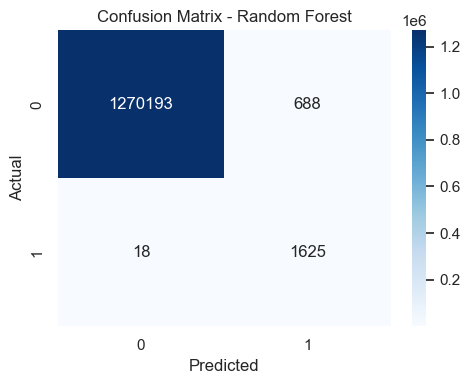

array([[1270193,     688],
       [     18,    1625]])

In [5]:
cm = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, "confusion_matrix_rf.png"), dpi=300)
plt.show()

cm


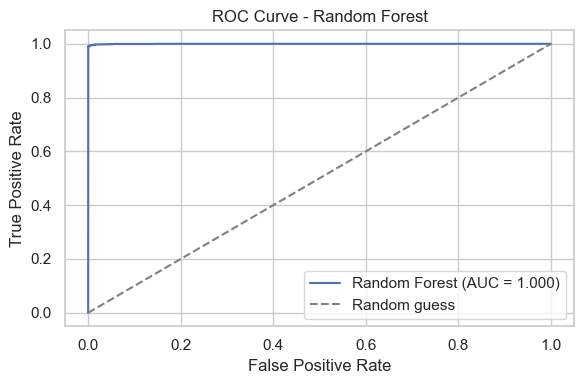

0.9997778686632067

In [6]:
y_scores_rf = rf_clf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_scores_rf)
auc_rf = roc_auc_score(y_test, y_scores_rf)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()

plt.tight_layout()
plt.savefig(os.path.join(IMAGES_DIR, "roc_curve_rf.png"), dpi=300)
plt.show()

auc_rf


## 🧠 Business Interpretation

- High **recall** for fraud means we **catch more real fraud attempts**
- Balanced precision avoids too many false alerts → better user experience
- Random Forest performs better than Logistic Regression due to:
  - nonlinear decision boundaries
  - patterns of engineered risk features
- ROC-AUC shows model is capable of recognizing fraud with good separation power

